In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as matplot
import seaborn as sns
import operator
import collections
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
%matplotlib inline
matplot.style.use('seaborn-whitegrid')
matplot.rcParams["figure.figsize"] = (15,15)

#read the csv file
df = pd.read_csv('Ames_Housing_data.csv')

In [2]:
#View the missing data
df.isnull().sum()[df.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [3]:
#Fill the NA value of LotFrontage with the mean value of the whole column
for i in range(0, len(df['LotFrontage'])):
    df['LotFrontage'].fillna(df['LotFrontage'].mean() , inplace = True)

#Fill the GarageYrBlt NA value with the mean value of the whole column
for i in range(0, len(df['GarageYrBlt'])):
    df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean() , inplace = True)

#Fill NaN with String 'NA'
df = df.fillna('NA')

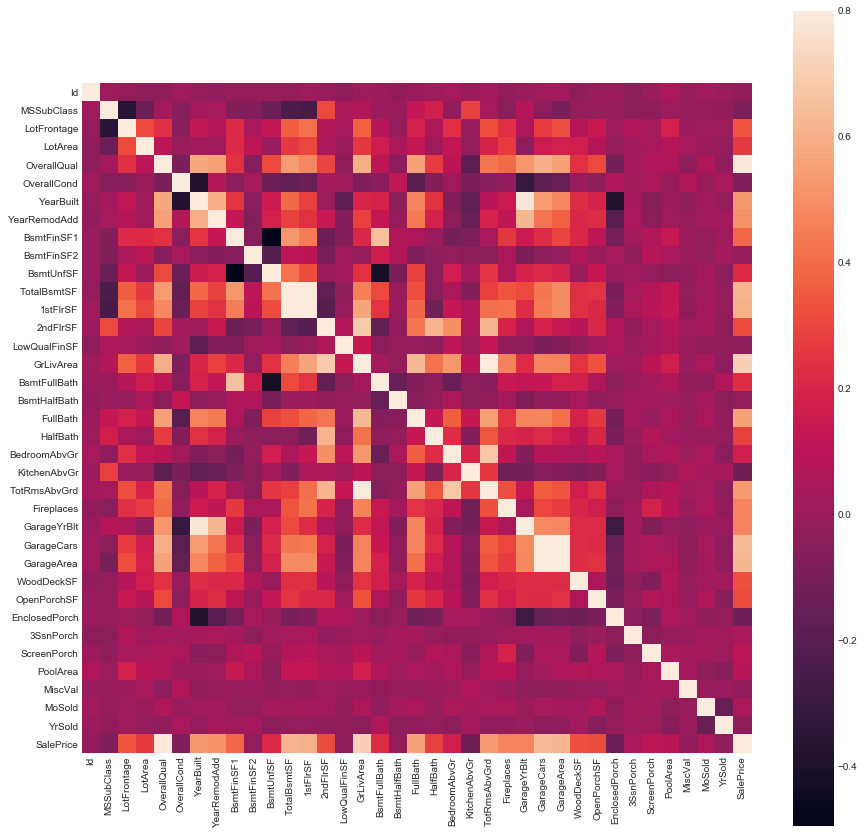

In [4]:
#Correlation heatmap
sns.heatmap(df.corr(), vmax=.8, square=True)

In [5]:
#Drop these categories since they seem to have no influence on the SalePrice or they have too much NA value
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
  'GarageType', 'GarageFinish','BsmtExposure', 'BsmtFinType2', 'BsmtFinType1',
 'MasVnrArea', 'MasVnrType', 'PoolArea'], axis = 1, inplace = True)

#We drop the row that has electrical as NA
df.drop(df[df.Electrical.isna()].index, axis = 0, inplace = True)

#For these variable, we concatenate into a new column, remove them and keep the concatenated column
df = df.assign(TotalFullBath = df['BsmtFullBath'] + df['FullBath'])
df.drop(['BsmtFullBath', 'FullBath'],axis = 1, inplace = True)
df = df.assign(TotalHalfBath = df['BsmtHalfBath'] + df['HalfBath'])
df.drop(['BsmtHalfBath', 'HalfBath'],axis = 1, inplace = True)
df.drop(['3SsnPorch', 'ScreenPorch', 'EnclosedPorch'],axis = 1, inplace = True)

In [6]:
#The list of all the numeric features in the data
numeric_features = df.dtypes[df.dtypes != "object"].index

In [7]:
#See the summary of SalePrice column
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
#The function to encoding some of the categorical variable that has the scale based on SalePrice
def encoding(column):
    list = set(df[column])
    dict = {key: 0 for key in list}
    for i in dict:
        sum = 0
        count = 0
        for k in range (len(df[column])):
            if(df[column][k] == i):
                sum = sum + df['SalePrice'][k]
                count = count + 1
        dict[i] = sum / count

    dict = collections.OrderedDict(sorted(dict.items(), key=lambda x: x[1]))

    count = 1
    for i in dict:
        dict[i] = count
        count = count + 1
    return dict

#These categorical variables have the scale based on SalePrice. We will identify the categories that have the highest SalePrice
#and give that categories the highest value, then do the same for the rest of other categories.
df['HouseStyle'] = df['HouseStyle'].map(encoding('HouseStyle'))
df['Neighborhood'] = df['Neighborhood'].map(encoding('Neighborhood'))
df['MSZoning'] = df['MSZoning'].map(encoding('MSZoning'))

In [9]:
#The encoding map
mp = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}

#These categorical variable have the categories map above
for feat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
 'HeatingQC', 'KitchenQual','GarageQual', 'GarageCond']:
     df[feat] = df[feat].map(mp)

#The encoding map
mp = {'N':0, 'Y':2 , 'P':1}

#These categorical variable have the categories map above
for feat in ['CentralAir', 'PavedDrive']:
    df[feat] = df[feat].map(mp)

#The encoding map
mp = {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1}

#These categorical variable have the categories map above
df['Functional'] = df['Functional'].map(mp)

#The encoding map
mp = {'Gtl':1 ,'Mod':2 , 'Sev':3}

#These categorical variable have the categories map above
df['LandSlope'] = df['LandSlope'].map(mp)

#We fill the NaN in these column with NA
NA = [ 'GarageQual', 'GarageCond', 'BsmtCond', 'BsmtQual']
for na in NA:
    df[na].fillna('NA', inplace = True)

In [10]:
#Remove outliers
outlier_features = ['LotFrontage', 'LotArea','SalePrice', 'GarageArea']
for i in outlier_features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df.drop(df[(df[i] > Q3 + IQR * 1.5) | (df[i] < Q1 - IQR * 1.5)].index, inplace = True)
df.drop(df[df["GrLivArea"] > 4000].index, inplace=True)

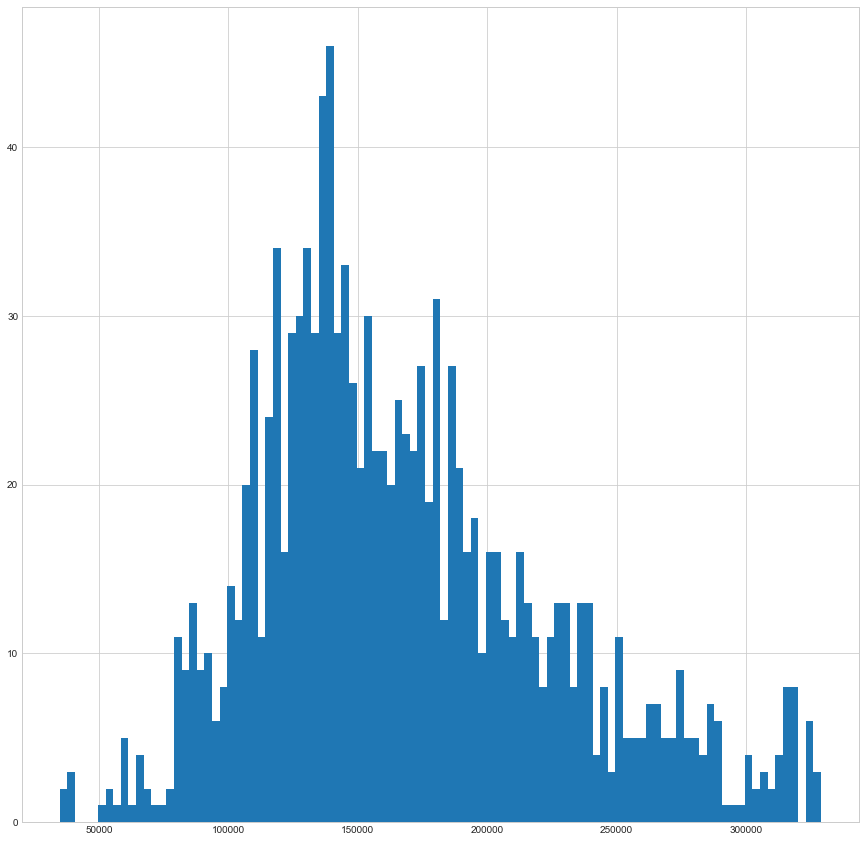

In [11]:
#Histogram for the SalePrice distribution
matplot.hist(df['SalePrice'], label = 'SalePrice', bins = 100)
matplot.show()

Text(0.5, 0, 'Ground Living Area')

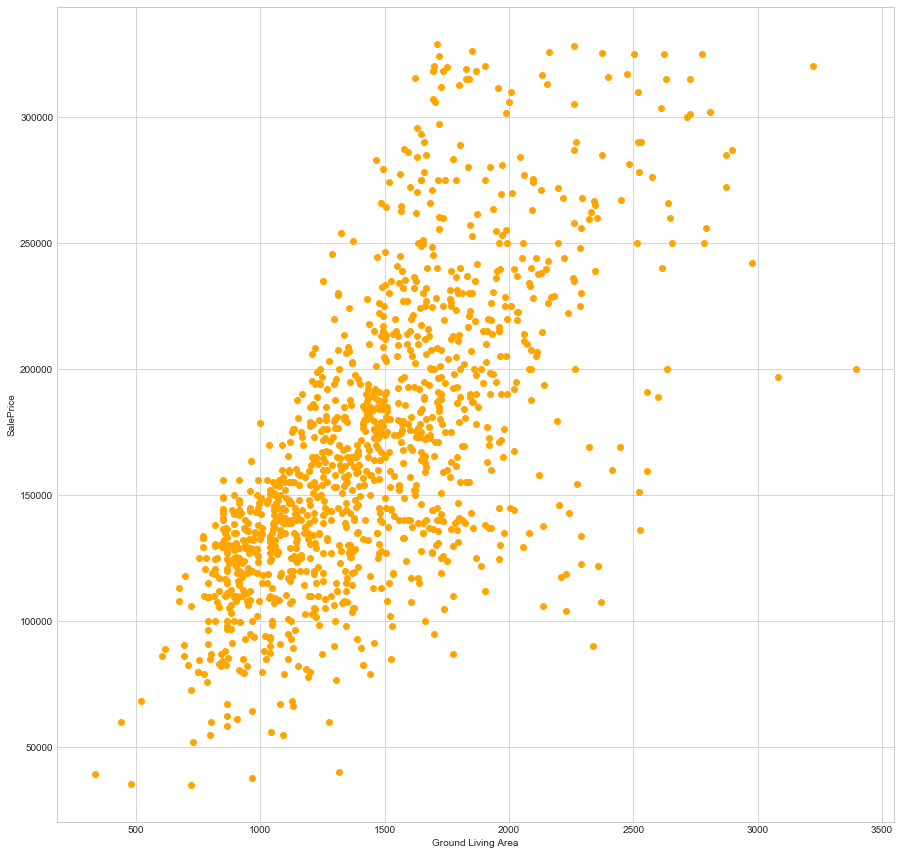

In [12]:
#Scatterplot for GroundLivingArea versus SalePrice
matplot.plot(df['GrLivArea'],df['SalePrice'],'o', color = 'orange')
matplot.ylabel('SalePrice')
matplot.xlabel('Ground Living Area')

Text(0.5, 0, 'Total square feet of basement area')

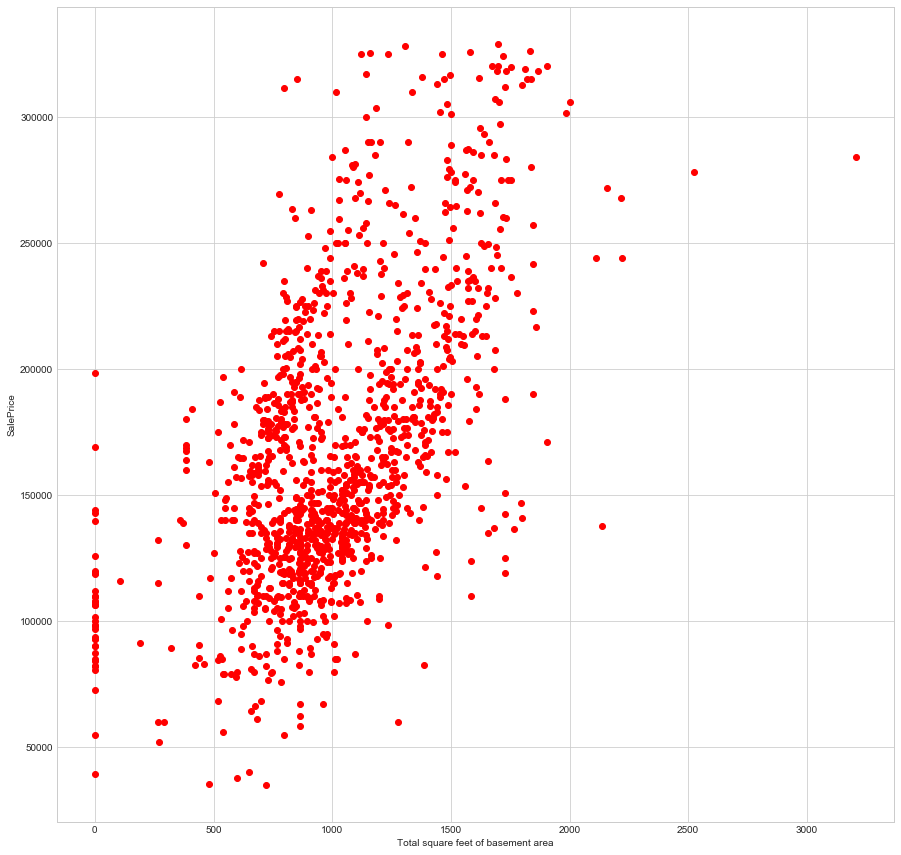

In [13]:
#Scatterplot for total square feet of basement area versus SalePrice
matplot.plot(df['TotalBsmtSF'], df["SalePrice"], 'o', color = 'red')
matplot.ylabel('SalePrice')
matplot.xlabel('Total square feet of basement area')

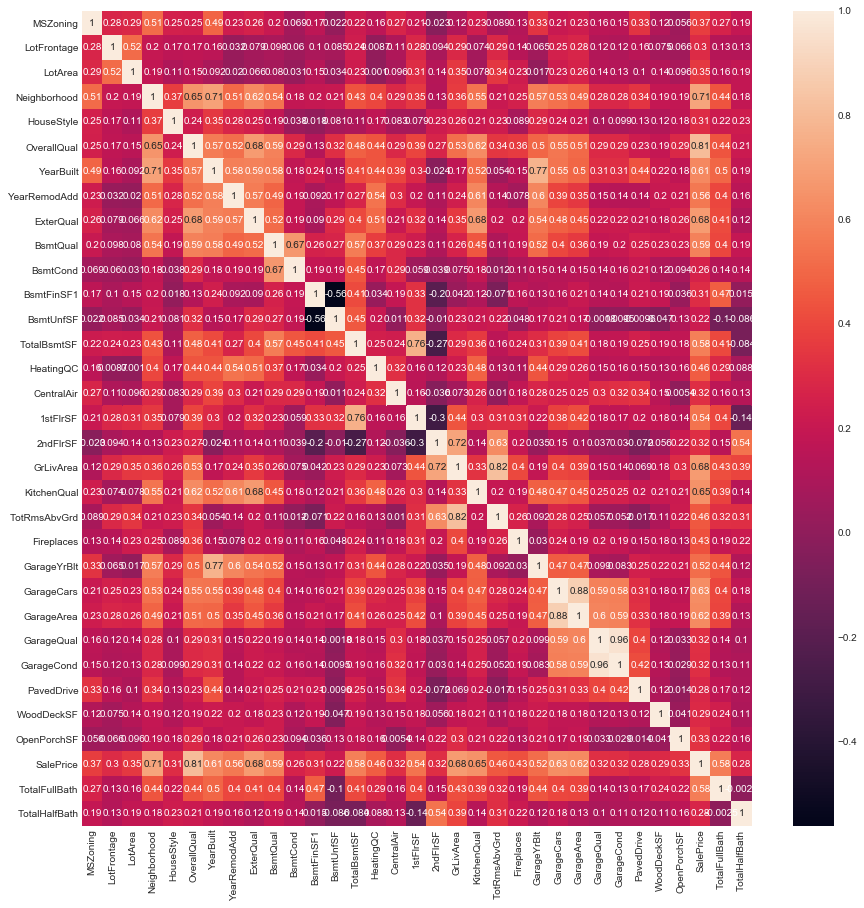

In [14]:
#Remove column with correlated values lower than 0.2
corr = df.corr()
rel_vars = corr.SalePrice[(corr.SalePrice > 0.2)]
rel_cols = list(rel_vars.index.values)

#Correlation HeatMap after removing column with correlated values lower than 0.2
corr2 = df[rel_cols].corr()
sns.heatmap(corr2, annot=True, annot_kws={'size':10})

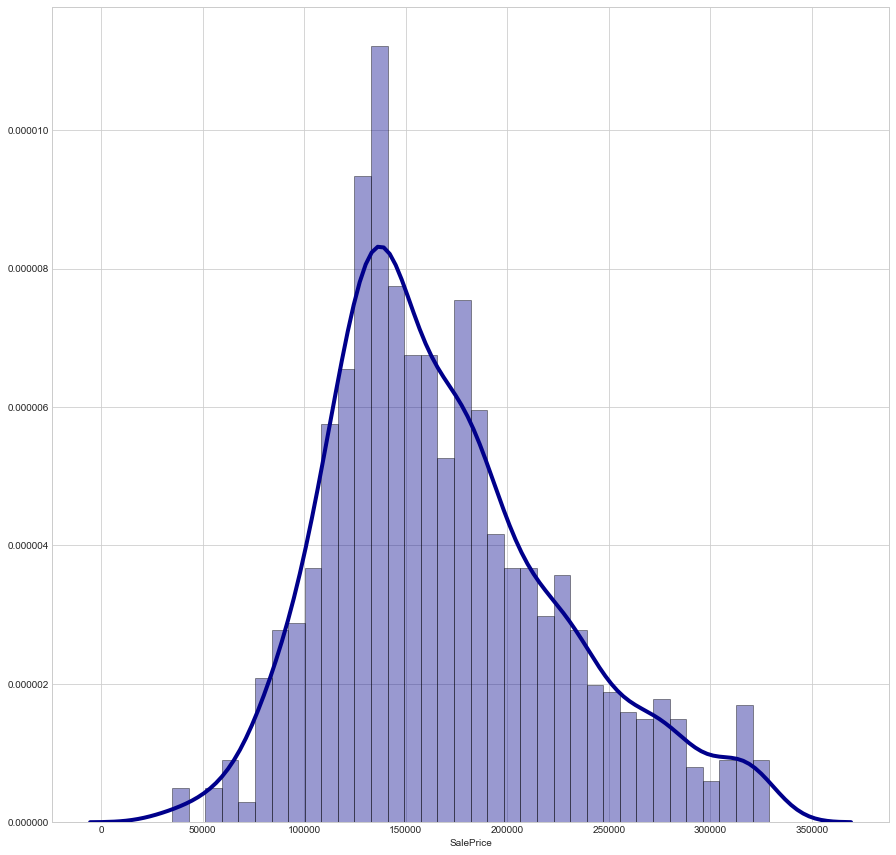

In [15]:
#SalePrice distribution with a curve goes over
sns.distplot(df['SalePrice'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.set_style("whitegrid")

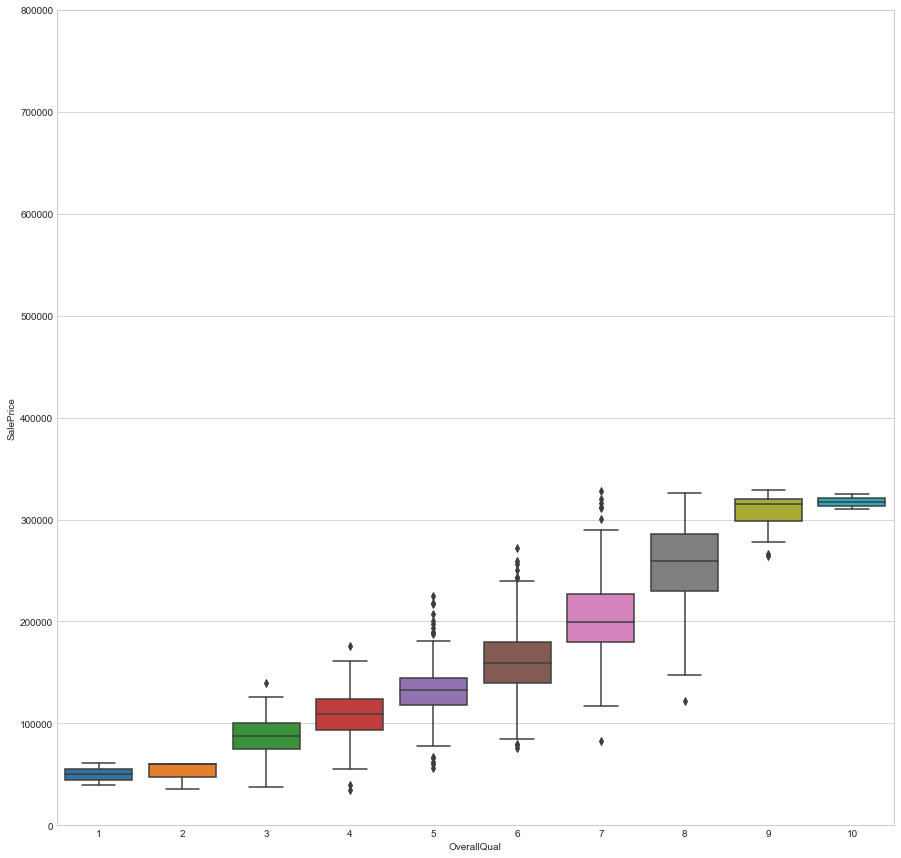

In [16]:
#Overall Quality visualization
var = 'OverallQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = matplot.subplots()
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


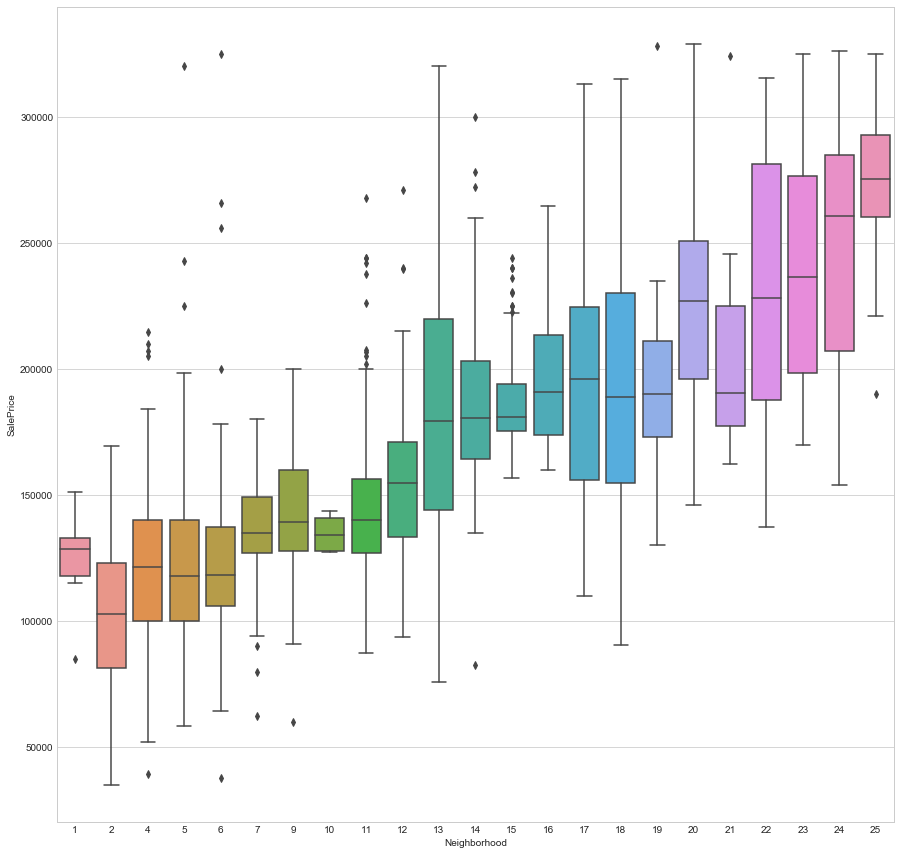

In [17]:
#Neighborhood versus SalePrice visualization
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = df)

In [18]:
from scipy.stats import skew

#Logarithm transformation for skew data column
skewed = df[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
df[skewed] = np.log1p(df[skewed])
df = pd.get_dummies(df)

In [19]:
#Train_test split
X = df.drop('SalePrice', axis = 1)
Y = df['SalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= 40)

In [20]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
import xgboost as xgboost
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import lightgbm as lgb

#Function to show the model result, including bar graphs
def result(model):
    Y_pred = model.predict(X_test)
    result = pd.DataFrame({'Actual': (Y_test), 'Predicted': (Y_pred)})
    
    print('THe accuracy of training set si is ', model.score(X_train, Y_train))
    print('THe accuracy of testing set si is ', model.score(X_test, Y_test))
    
    df1 = result.head(30)
    print(df1)
    df1.plot(kind='bar',figsize=(10,8))
    
    kfold = KFold(n_splits = 10, random_state=7, shuffle = True)
    results = np.sqrt(-cross_val_score(model, X_test, Y_test, cv=kfold, scoring = 'neg_mean_squared_error'))
    
    print("The root mean squared error is " + str(results.mean()) + " " + "(" + str(results.std()) + ")")

THe accuracy of training set si is  0.8796806105633481
THe accuracy of testing set si is  0.8905256532855628
      Actual      Predicted
360   156000  155538.550759
577   164500  168902.435909
809   106000  147948.769050
466   167000  179993.910860
1205  271900  242980.349597
575   118500  115809.690150
1098  128000  100425.161192
491   133000  136056.758155
1389  131000  132032.391603
152   190000  187922.095955
540   315000  284897.159249
840   140000  132709.425750
315   188500  204555.867016
814   116000  114022.266887
57    196500  210173.721683
125    84500   86747.394730
490   115000  128634.029102
1026  167500  147860.390947
1129  140000  121663.636359
896   106500   96719.918310
650   205950  209018.614053
329    78000   91884.307419
533    39300   16029.186240
428   195400  203308.172236
867   129000  128501.755448
326   324000  260198.157147
1165  233170  216735.542538
1163  108959  129828.351549
1440  191000  203591.749146
1320  156500  172261.103226
The root mean squared e

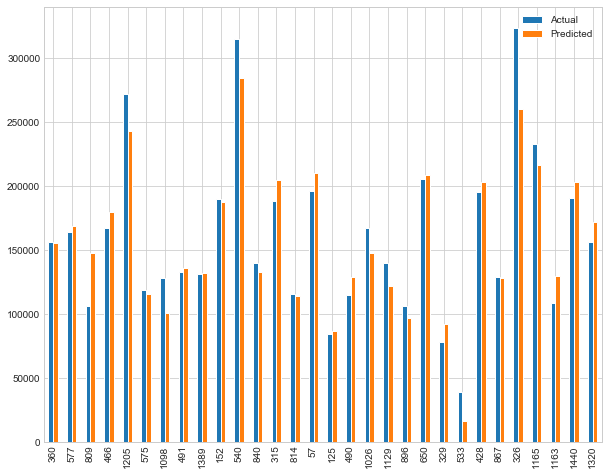

In [21]:
#Ridge model
ridge = Ridge(alpha = 1, normalize = True)
Ridge_pipeline = make_pipeline(ridge)
Ridge_pipeline.fit(X_train, Y_train)
result(Ridge_pipeline)

THe accuracy of training set si is  0.9999999983740075
THe accuracy of testing set si is  0.9263523107688323
      Actual      Predicted
360   156000  144846.015625
577   164500  149767.765625
809   106000  127374.007812
466   167000  151926.515625
1205  271900  273705.718750
575   118500  113066.820312
1098  128000  117967.312500
491   133000  150891.109375
1389  131000  127451.945312
152   190000  202627.906250
540   315000  356600.718750
840   140000  131970.500000
315   188500  184857.578125
814   116000  121816.218750
57    196500  201350.187500
125    84500   92590.781250
490   115000  121148.156250
1026  167500  141827.046875
1129  140000  125520.828125
896   106500   90266.296875
650   205950  201884.703125
329    78000   84085.703125
533    39300   40253.730469
428   195400  197910.500000
867   129000  131785.765625
326   324000  295699.687500
1165  233170  219087.484375
1163  108959  134574.734375
1440  191000  208222.953125
1320  156500  142986.750000
The root mean squared e

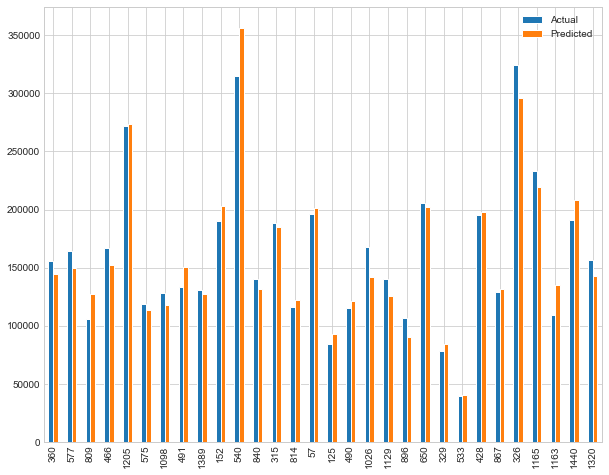

In [22]:
#XGBoost model
xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
XGB_pipeline = make_pipeline(xgb)
XGB_pipeline.fit(X_train, Y_train)
result(XGB_pipeline)

THe accuracy of training set si is  0.9030121378865386
THe accuracy of testing set si is  0.8831597999841714
      Actual      Predicted
360   156000  144362.694602
577   164500  148584.236266
809   106000  146097.536144
466   167000  191906.078663
1205  271900  273142.735992
575   118500  119886.335702
1098  128000  100154.951372
491   133000  151044.378986
1389  131000  122097.037374
152   190000  189504.081192
540   315000  317535.699292
840   140000  145129.376014
315   188500  195984.636790
814   116000  101711.102100
57    196500  214541.305963
125    84500  114406.512926
490   115000   96399.290547
1026  167500  144077.764610
1129  140000  131803.724146
896   106500   84572.847144
650   205950  218637.095002
329    78000   87497.556608
533    39300   -8857.762650
428   195400  206237.154516
867   129000  111777.395701
326   324000  297345.847088
1165  233170  220161.508394
1163  108959  135356.521703
1440  191000  204223.701586
1320  156500  164111.082758
The root mean squared e

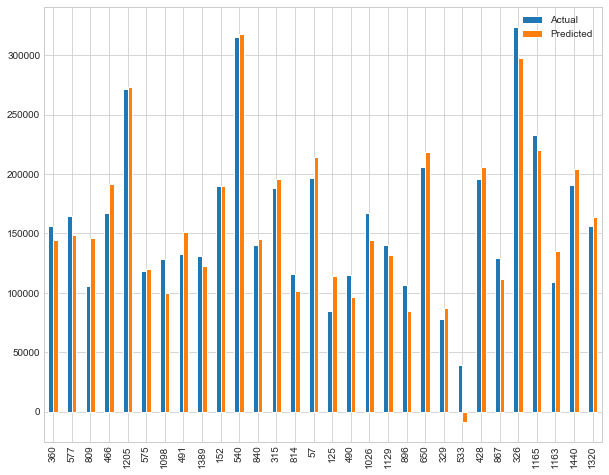

In [23]:
#Lasso model
lasso_pipeline = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1, tol = 0.1))
lasso_pipeline.fit(X_train, Y_train)
result(lasso_pipeline)

THe accuracy of training set si is  0.9030732322509623
THe accuracy of testing set si is  0.8838636543981571
      Actual      Predicted
360   156000  144310.846547
577   164500  148638.119042
809   106000  145819.883481
466   167000  191515.123843
1205  271900  273254.898687
575   118500  119831.406401
1098  128000  100182.280403
491   133000  151069.444542
1389  131000  122218.372922
152   190000  189438.377378
540   315000  317556.103259
840   140000  145155.117879
315   188500  196016.095003
814   116000  101744.620632
57    196500  214551.804114
125    84500  114080.232404
490   115000   96412.116630
1026  167500  144040.586141
1129  140000  131770.015914
896   106500   84674.000753
650   205950  218624.979049
329    78000   87656.775109
533    39300   -9057.190386
428   195400  206259.399626
867   129000  111772.035311
326   324000  296506.725415
1165  233170  220215.291901
1163  108959  135217.568341
1440  191000  204129.745628
1320  156500  164166.878305
The root mean squared e

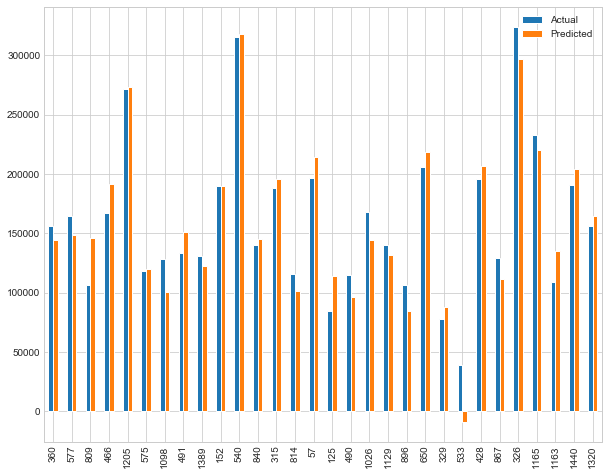

In [24]:
#ElasticNet model
ENet_pipeline = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3, tol = 0.1))
ENet_pipeline.fit(X_train, Y_train)
result(ENet_pipeline)

THe accuracy of training set si is  0.9151983631400771
THe accuracy of testing set si is  0.9068404049309187
      Actual      Predicted
360   156000  153386.010254
577   164500  160338.344727
809   106000  170471.194824
466   167000  169848.931152
1205  271900  273849.828125
575   118500  113465.717773
1098  128000   98954.902588
491   133000  154604.953613
1389  131000  113163.393066
152   190000  188562.014648
540   315000  308962.065918
840   140000  140629.283691
315   188500  195270.957520
814   116000  108068.720703
57    196500  210293.298340
125    84500   96662.711914
490   115000  114753.015869
1026  167500  139267.123535
1129  140000  121182.115234
896   106500   84013.096680
650   205950  214494.936523
329    78000   85401.610352
533    39300   17958.665283
428   195400  204445.267090
867   129000  115485.109863
326   324000  277289.775391
1165  233170  217646.057617
1163  108959  130638.349609
1440  191000  202858.217773
1320  156500  161094.994629
The root mean squared e

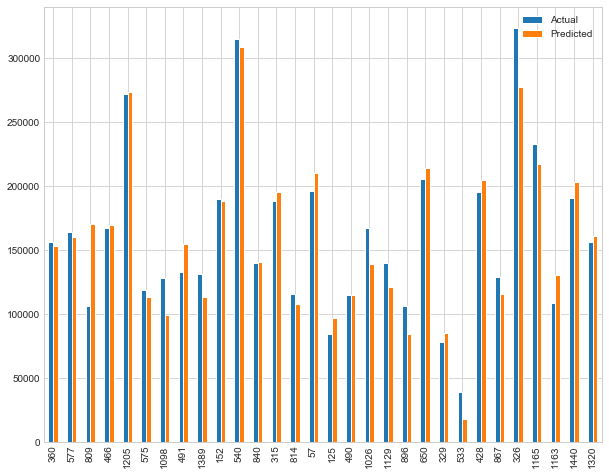

In [25]:
#Kernel Ridge model
KRR_pipeline = KernelRidge(alpha=0.05, kernel='polynomial', degree = 1, coef0 = 2)
KRR_pipeline.fit(X_train, Y_train)
result(KRR_pipeline)

THe accuracy of training set si is  0.9823743203543698
THe accuracy of testing set si is  0.8836589459088673
      Actual      Predicted
360   156000  138396.057500
577   164500  151436.353750
809   106000  125292.911667
466   167000  152927.502083
1205  271900  247889.259583
575   118500  120858.282083
1098  128000  112536.977500
491   133000  141327.042083
1389  131000  126210.496667
152   190000  197270.759583
540   315000  313636.595833
840   140000  133251.485000
315   188500  181909.270833
814   116000  112806.108750
57    196500  198231.854583
125    84500  100727.208333
490   115000  122060.392083
1026  167500  147412.784583
1129  140000  131990.938750
896   106500   96798.804167
650   205950  189013.185000
329    78000   97949.374583
533    39300   61234.126250
428   195400  196084.739167
867   129000  130240.956250
326   324000  268502.890000
1165  233170  227645.890000
1163  108959  137064.827500
1440  191000  204798.234167
1320  156500  160817.260000
The root mean squared e

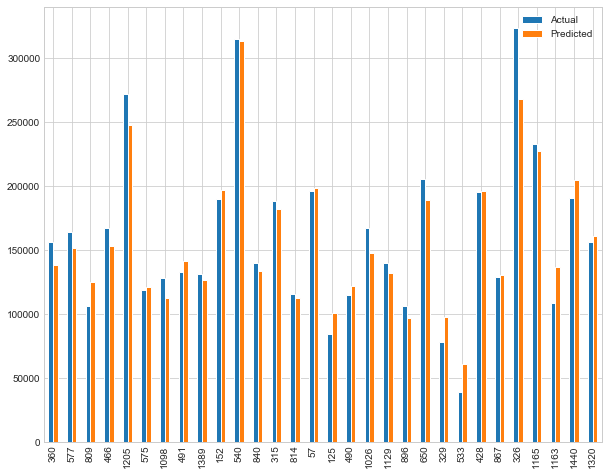

In [26]:
#RandomForestRegressor model
MAXDEPTH = 60
rf_model = RandomForestRegressor(n_estimators=2400,  
                             max_depth= MAXDEPTH,     
                             min_samples_split= 2,    
                             oob_score = True,        
                             n_jobs = -1,             
                             )
rf_model.fit(X_train,Y_train)
result(rf_model)

THe accuracy of training set si is  0.9900462134414724
THe accuracy of testing set si is  0.9307514323624226
      Actual      Predicted
360   156000  146375.422514
577   164500  152153.589411
809   106000  115835.187938
466   167000  153885.197731
1205  271900  268854.900780
575   118500  112293.246972
1098  128000  116080.427168
491   133000  146594.642153
1389  131000  131827.215605
152   190000  212155.947798
540   315000  336558.283638
840   140000  132784.153405
315   188500  182211.597511
814   116000  114849.628529
57    196500  193542.195659
125    84500   94673.698793
490   115000  116897.810460
1026  167500  142635.559270
1129  140000  129792.641061
896   106500   94358.177254
650   205950  202784.041631
329    78000   88213.467676
533    39300   51214.276571
428   195400  194994.922399
867   129000  136448.142162
326   324000  295012.866575
1165  233170  230559.556419
1163  108959  122463.884702
1440  191000  207568.226799
1320  156500  152069.946856
The root mean squared e

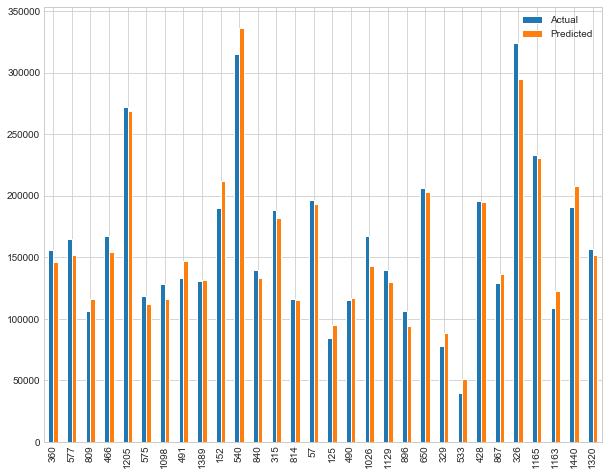

In [27]:
#Gradient Boosting model
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
Gboost_pipeline = make_pipeline(GBoost)
Gboost_pipeline.fit(X_train, Y_train)
result(Gboost_pipeline)

THe accuracy of training set si is  0.9714314282627309
THe accuracy of testing set si is  0.9308682880618266
      Actual      Predicted
360   156000  144870.715777
577   164500  157632.406991
809   106000  121210.901260
466   167000  151411.806694
1205  271900  261607.832218
575   118500  111952.419170
1098  128000  103840.836570
491   133000  152727.921033
1389  131000  133582.039095
152   190000  195792.056985
540   315000  345505.127939
840   140000  138303.494827
315   188500  190814.372469
814   116000  116527.599388
57    196500  198713.604828
125    84500   99019.976560
490   115000  111383.477218
1026  167500  140469.268334
1129  140000  122455.789753
896   106500   95708.323539
650   205950  197497.491790
329    78000   88297.876273
533    39300   48472.510120
428   195400  198610.449554
867   129000  132985.174773
326   324000  286288.569740
1165  233170  231308.877885
1163  108959  119518.526025
1440  191000  206377.047301
1320  156500  157119.987294
The root mean squared e

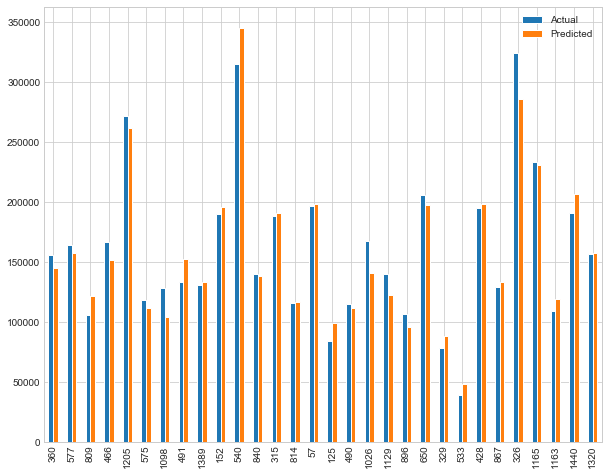

In [28]:
#LightGBM model
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
gbm_pipeline = make_pipeline(gbm)
gbm_pipeline.fit(X_train, Y_train)
result(gbm_pipeline)